# Decipher Quick Start Tutorial

Decipher is a model for jointly analyzing single-cell RNA-seq samples from distinct conditions (e.g. normal vs perturbed samples). This tutorial will guide you through the steps to use Decipher to analyze a dataset.

**Note:** This tutorial currently only features a basic Decipher model. A more fleshed out implemention aligned with the [original implementation](https://github.com/azizilab/decipher) is currently in development and will be released soon along with updates to this tutorial.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [4]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
from scvi.external import Decipher

scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = tempfile.TemporaryDirectory()

/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packa

Last run with scvi-tools version: 1.2.0


## Preprocessing and model fitting

For this tutorial, we will use a subset of the AML data from the [Decipher preprint](https://www.biorxiv.org/content/10.1101/2023.11.11.566719v1) for the purpose of demonstrating how to use Decipher with scvi-tools.

In [6]:
adata_path = os.path.join(save_dir.name, "decipher_tutorial_data.h5ad")

adata = sc.read(adata_path, backup_url="https://github.com/azizilab/decipher_data/raw/refs/heads/main/data_decipher_tutorial.h5ad")
adata = adata[~adata.obs["cell_type"].isin(["mep", "ery", "lympho"])].copy() # subset to only include relevant cell types

adata

AnnData object with n_obs × n_vars = 16627 × 3130
    obs: 'cell_type', 'origin', 'NPM1 mutation vs wild type'
    uns: 'color_palette', 'decipher'
    obsm: 'X_pca', 'X_tsne', 'decipher_v', 'decipher_z'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Decipher does not require any additional covariates, and only optionally takes a `layer` indicating which layer of the AnnData object contains the raw count data.

In [7]:
Decipher.setup_anndata(adata)

Now we are ready to fit the model.

In [8]:
model = Decipher(adata)
model.train(
    max_epochs=100,
    batch_size=64,
    early_stopping=True,
    early_stopping_patience=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/justin/miniconda3/envs/decipherdev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloa

Epoch 59/100:  59%|█████▉    | 59/100 [00:49<00:34,  1.19it/s, v_num=1, elbo_validation=3.48e+3, elbo_train=3.48e+3]
Monitored metric nll_validation did not improve in the last 10 records. Best score: 3489.449. Signaling Trainer to stop.


In [9]:
# save load functionality
save_path = f"./_decipher_models/test_notebook_model_{scvi.settings.seed}"
model.save(save_path, overwrite=True)
model = Decipher.load(save_path, adata)

INFO     File ./_decipher_models/test_notebook_model_0/model.pt already downloaded                                 


/home/justin/ghrepos/scvi-tools/src/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_location)

Epoch 1/1000:   0%|          | 1/1000 [00:00<00:07, 135.46it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/1000:   0%|          | 1/1000 [00:00<00:09, 109.30it/s, v_num=1]


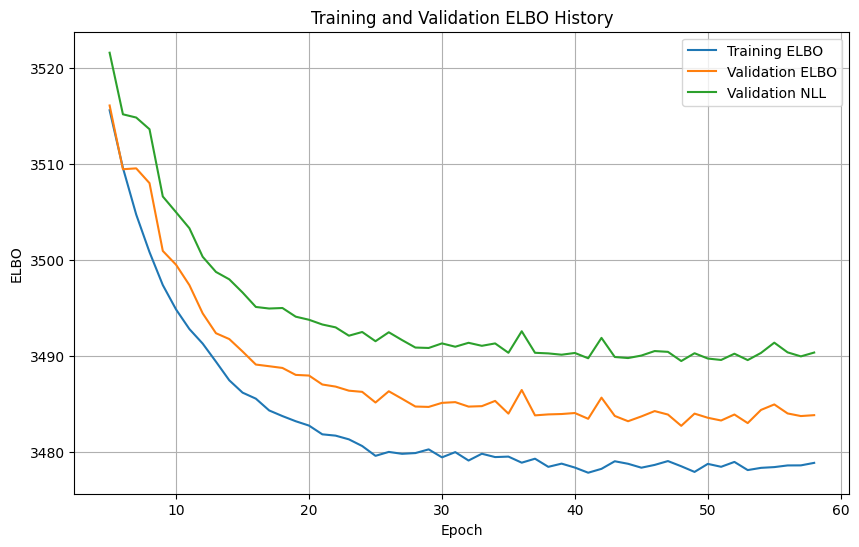

In [10]:
# Plot training and validation ELBO history
plt.figure(figsize=(10, 6))
plt.plot(model.history_["elbo_train"][5:], label="Training ELBO")
plt.plot(model.history_["elbo_validation"][5:], label="Validation ELBO")
plt.plot(model.history_["nll_validation"][5:], label="Validation NLL")
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.title("Training and Validation ELBO History")
plt.legend()
plt.grid(True)
plt.show()

# Visualize the latent representation

Now that we have confirmed the model has converged, we can visualize the latent representation.

Notably, Decipher has two latent representations: `v` and `z`. `v` is a 2-dimensional latent representation which is amenable to direct visualization, while `z` is a higher-dimensional latent representation which is designed to capture more refined cell state information such as transitional intermediates.

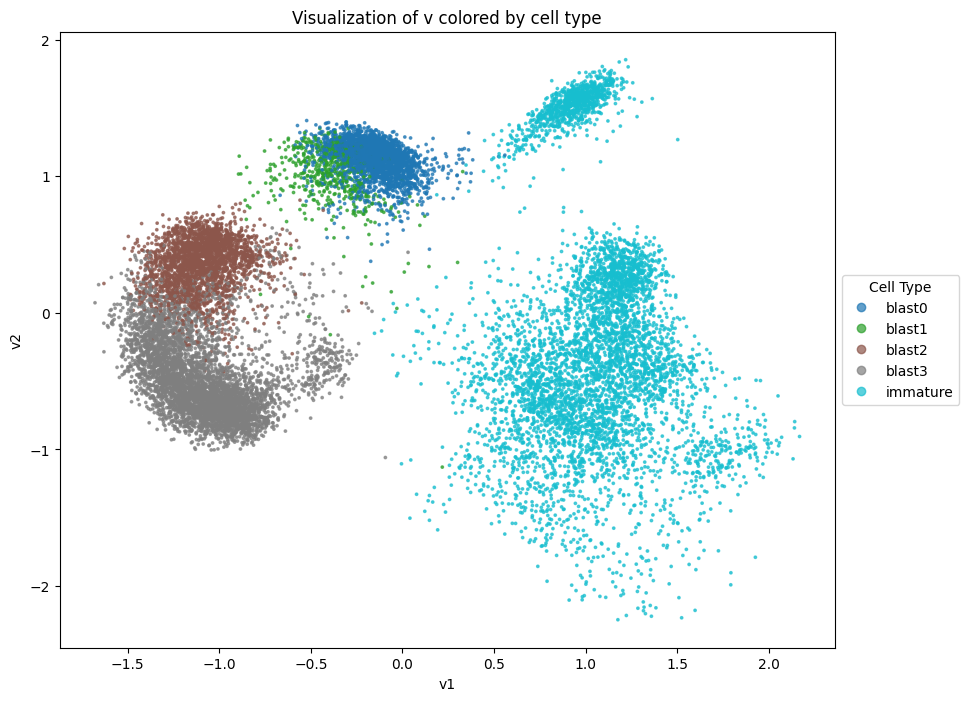

In [11]:
v = model.get_latent_representation()
# Plot v and color by cell type
cell_type_mapping = adata.obs["cell_type"].astype("category").cat
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    v[:, 0], v[:, 1], c=cell_type_mapping.codes, cmap="tab10", alpha=0.7, s=3
)

plt.legend(
    scatter.legend_elements()[0],
    cell_type_mapping.categories,
    title="Cell Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

plt.title("Visualization of v colored by cell type")
plt.xlabel("v1")
plt.ylabel("v2")
plt.show()

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


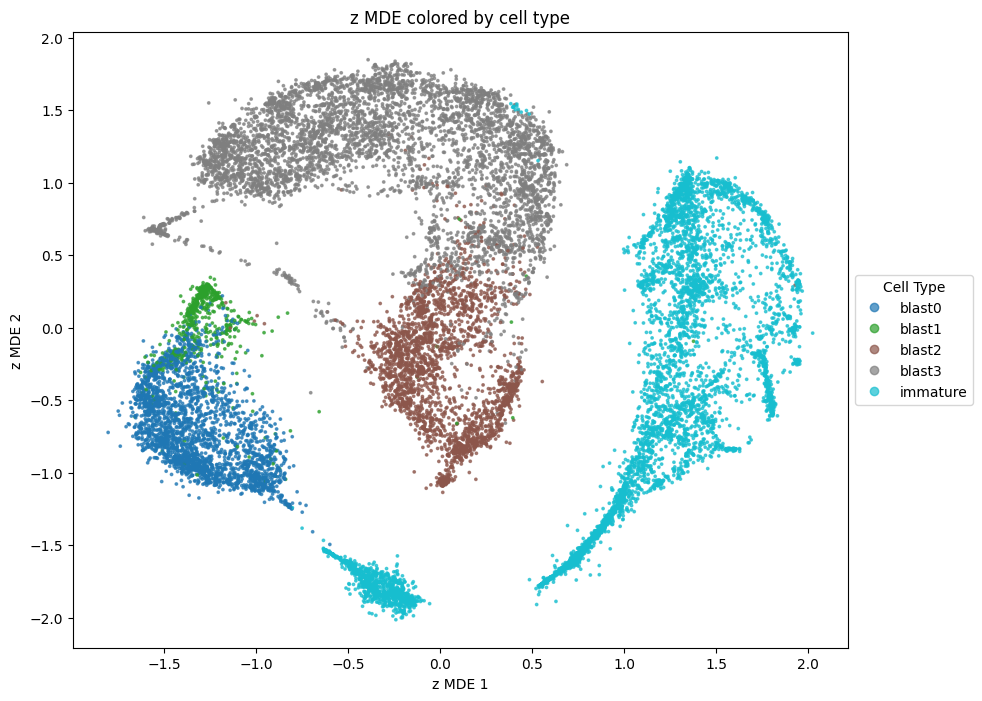

In [13]:
z = model.get_latent_representation(give_z=True)
z_mde = scvi.model.utils.mde(z)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    z_mde[:, 0], z_mde[:, 1], c=cell_type_mapping.codes, cmap="tab10", alpha=0.7, s=3
)

plt.legend(
    scatter.legend_elements()[0],
    cell_type_mapping.categories,
    title="Cell Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

plt.title("z MDE colored by cell type")
plt.xlabel("z MDE 1")
plt.ylabel("z MDE 2")
plt.show()